# Analisis Sentiman terhadap Ulasan pada Aplikasi Dana di Play Store

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 1. Loading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

rv_dana_df = pd.read_csv('/content/drive/MyDrive/submission-1/review_dana.csv')

Mounted at /content/drive


In [3]:
rv_dana_df.to_csv('review_dana.csv', index=False)
jumlah_review = rv_dana_df.shape[0]
print(f'Jumlah review: {jumlah_review}')
rv_dana_df.head()

Jumlah review: 139500


,Review
0,Ini gimana sih biasanya gak pakai verifikasi w...
1,"masih ribet, kurang simpel proses premiumnya. ..."
2,Tidak mudah membuat laporan keluhan.. ketika m...
3,menurut saya apknya kurang dalam hal transaksi...
4,Kenapa saldo saya tbtb terpotong otomatis pada...


In [4]:
rv_dana_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139500 entries, 0 to 139499
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  139500 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


In [5]:
clean_dana_df = rv_dana_df.dropna()
clean_dana_df.shape

(139500, 1)

In [6]:
clean_dana_df = clean_dana_df.drop_duplicates()
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom = clean_dana_df.shape
print(f'Jumlah ulasan setelah dihapus duplikat: {jumlah_ulasan_setelah_hapus_duplikat}')
print(f'Jumlah kolom: {jumlah_kolom}')
clean_dana_df.info()

Jumlah ulasan setelah dihapus duplikat: 137460
Jumlah kolom: 1
<class 'pandas.core.frame.DataFrame'>
Index: 137460 entries, 0 to 139499
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  137460 non-null  object
dtypes: object(1)
memory usage: 2.1+ MB


# 2. Preprocessing Text

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [9]:
def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'#', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r"https\S+", '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.replace('\n', ' ')
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.strip(' ')
  return text

def casefoldingText(text):
  return text.lower()

def tokenizingText(text):
  return word_tokenize(text)

def filteringText(text):
  listStopwords = set(stopwords.words('indonesian'))
  listStopwords1 = set(stopwords.words('english'))
  listStopwords.update(listStopwords1)
  listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woii','woy'])
  filtered = []
  for txt in text:
    if txt not in listStopwords:
      filtered.append(txt)
  text = filtered
  return text

def stemmingText(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  words = text.split()
  stemmed_words = [stemmer.stem(word) for word in words]
  stemmed_text = ' '.join(stemmed_words)
  return stemmed_text

def toSentence(list_words):
  sentence = ' '.join(word for word in list_words)
  return sentence

def fix_slangwords(text):
  slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
  words = text.split()
  fixed_words = [slangwords[word.lower()] if word.lower() in slangwords else word for word in words]
  return ' '.join(fixed_words)


In [10]:
def preprocess_df(df):
    df['text_clean'] = df['Review'].apply(cleaningText)
    df['text_casefolding'] = df['text_clean'].apply(casefoldingText)
    df['text_slangwords'] = df['text_casefolding'].apply(fix_slangwords)
    df['text_tokenizing'] = df['text_slangwords'].apply(tokenizingText)
    df['text_stopword'] = df['text_tokenizing'].apply(filteringText)
    df['text_akhir'] = df['text_stopword'].apply(toSentence)
    return df

In [11]:
clean_dana_df = preprocess_df(clean_dana_df)

In [12]:
clean_dana_df.head()

,Review,text_clean,text_casefolding,text_slangwords,text_tokenizing,text_stopword,text_akhir
0,Ini gimana sih biasanya gak pakai verifikasi w...,Ini gimana sih biasanya gak pakai verifikasi w...,ini gimana sih biasanya gak pakai verifikasi w...,ini bagaimana sih biasanya gak pakai verifikas...,"[ini, bagaimana, sih, biasanya, gak, pakai, ve...","[pakai, verifikasi, wajah, langsung, klik, tin...",pakai verifikasi wajah langsung klik tinggal m...
1,"masih ribet, kurang simpel proses premiumnya. ...",masih ribet kurang simpel proses premiumnya ve...,masih ribet kurang simpel proses premiumnya ve...,masih ribet kurang simpel proses premiumnya ve...,"[masih, ribet, kurang, simpel, proses, premium...","[ribet, simpel, proses, premiumnya, verifikasi...",ribet simpel proses premiumnya verifikasi upgr...
2,Tidak mudah membuat laporan keluhan.. ketika m...,Tidak mudah membuat laporan keluhan ketika mem...,tidak mudah membuat laporan keluhan ketika mem...,tidak mudah membuat laporan keluhan ketika mem...,"[tidak, mudah, membuat, laporan, keluhan, keti...","[mudah, laporan, keluhan, membuka, aplikasi, m...",mudah laporan keluhan membuka aplikasi menungg...
3,menurut saya apknya kurang dalam hal transaksi...,menurut saya apknya kurang dalam hal transaksi...,menurut saya apknya kurang dalam hal transaksi...,menurut saya apknya kurang dalam hal transaksi...,"[menurut, saya, apknya, kurang, dalam, hal, tr...","[apknya, transaksi, transaksi, sistem, apapun,...",apknya transaksi transaksi sistem apapun konfi...
4,Kenapa saldo saya tbtb terpotong otomatis pada...,Kenapa saldo saya tbtb terpotong otomatis pada...,kenapa saldo saya tbtb terpotong otomatis pada...,kenapa saldo saya tbtb terpotong otomatis pada...,"[kenapa, saldo, saya, tbtb, terpotong, otomati...","[saldo, tbtb, terpotong, otomatis, berlanggana...",saldo tbtb terpotong otomatis berlangganan apl...


# 3. Pelabelan Data

In [13]:
import csv
import requests
from io import StringIO

lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
  reader = csv.reader(StringIO(response.text), delimiter = ',')

  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

else:
  print("Failed to fetch positive lexicon data")

lexicon_negative = dict()
response =  requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
  reader = csv.reader(StringIO(response.text), delimiter = ',')

  for row in reader:
    lexicon_negative[row[0]] = int(row[1])

else:
  print("Failed to fetch negative lexicon data")

In [14]:
def sentimen_analysis_lexicon_indonesia(text):
  score = 0

  for word in text:
    if (word in lexicon_positive):
      score = score + lexicon_positive[word]

  for word in text:
    if (word in lexicon_negative):
      score = score + lexicon_negative[word]

  polarity = ''

  if (score > 0):
    polarity = 'positive'
  elif (score < 0):
    polarity = 'negative'
  else:
    polarity = 'neutral'

  return score, polarity

In [15]:
results = clean_dana_df['text_stopword'].apply(sentimen_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_dana_df['polarity_score'] = results[0]
clean_dana_df['polarity'] = results[1]
print(clean_dana_df['polarity'].value_counts())

polarity
positive    71661
negative    56287
neutral      9512
Name: count, dtype: int64


## 3.1 Visualisasi Sentimen Polarity

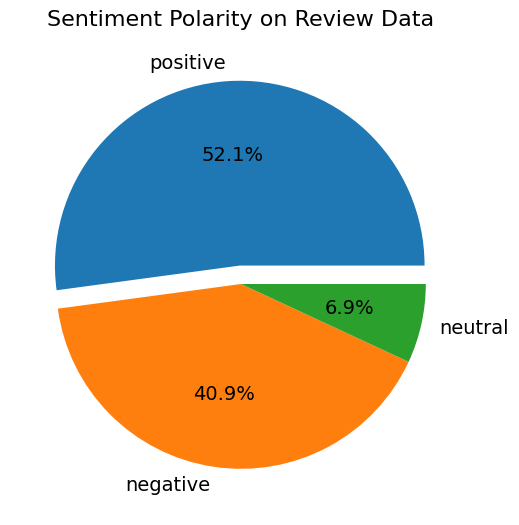

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in clean_dana_df['polarity'].value_counts()]
labels = list(clean_dana_df['polarity'].value_counts().index)
explode = (0.1, 0, 0)

ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

plt.show()

Terdapat **imbalance data** karena jumlah label neutral yang **jauh lebih sedikit** dari label mayoritas, oleh karena itu pada saat training model akan menggunakan teknik **oversampling**.

## 3.2 Visualisasi Word Word Cloud

In [17]:
pd.set_option('display.max_colwidth', 3000)

positive_tweets = clean_dana_df[clean_dana_df['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

positive_tweets = positive_tweets.reset_index(drop=True)
positive_tweets.index += 1

In [18]:
pd.set_option('display.max_colwidth', 3000)

negative_tweets = clean_dana_df[clean_dana_df['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)
negative_tweets = negative_tweets[0:10]

negative_tweets = negative_tweets.reset_index(drop=True)
negative_tweets.index += 1

In [19]:
pd.set_option('display.max_colwidth', 3000)

neutral_tweets = clean_dana_df[clean_dana_df['polarity'] == 'negative']
neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=True)
neutral_tweets = neutral_tweets[0:10]

neutral_tweets = neutral_tweets.reset_index(drop=True)
neutral_tweets.index += 1

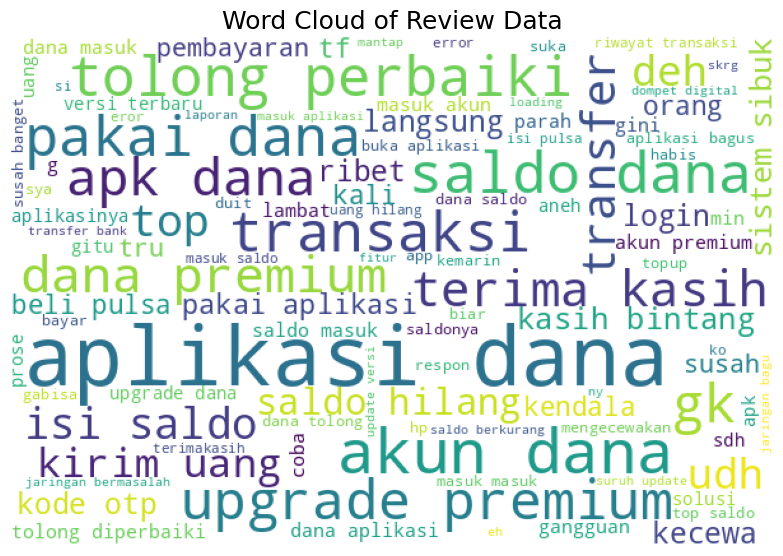

In [20]:
list_words = ''

for tweet in clean_dana_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Review Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

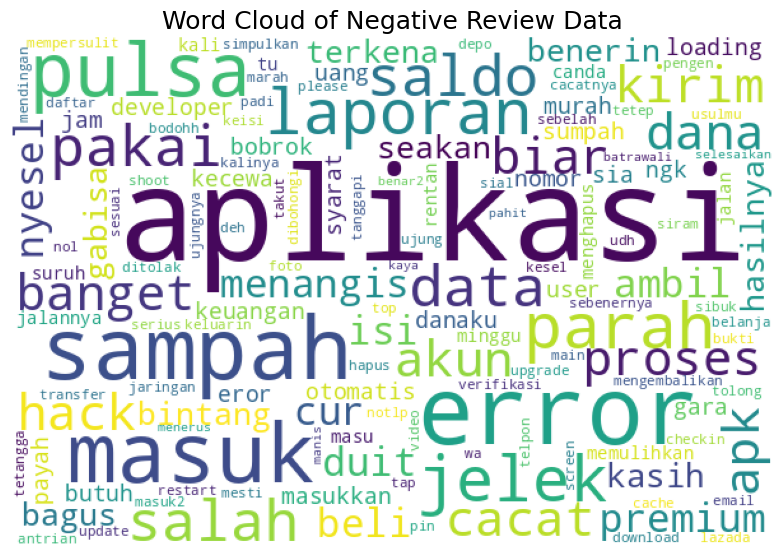

In [21]:
list_words = ''

for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Review Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

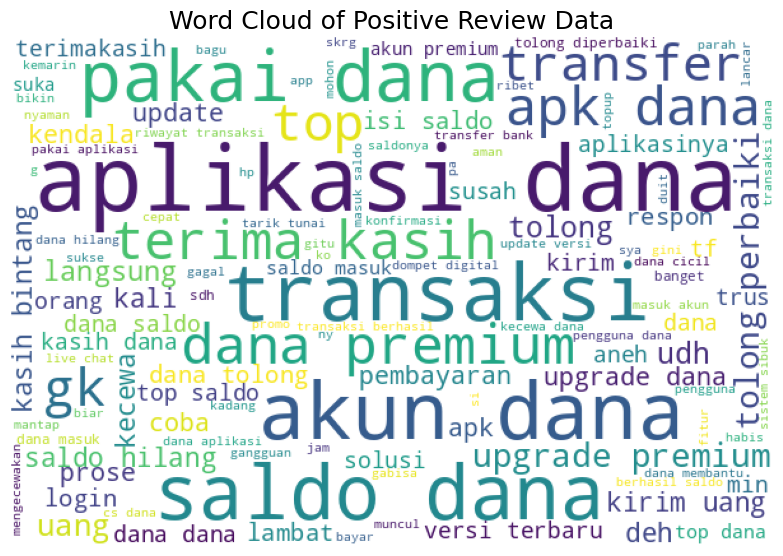

In [22]:
list_words = ''

for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Review Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

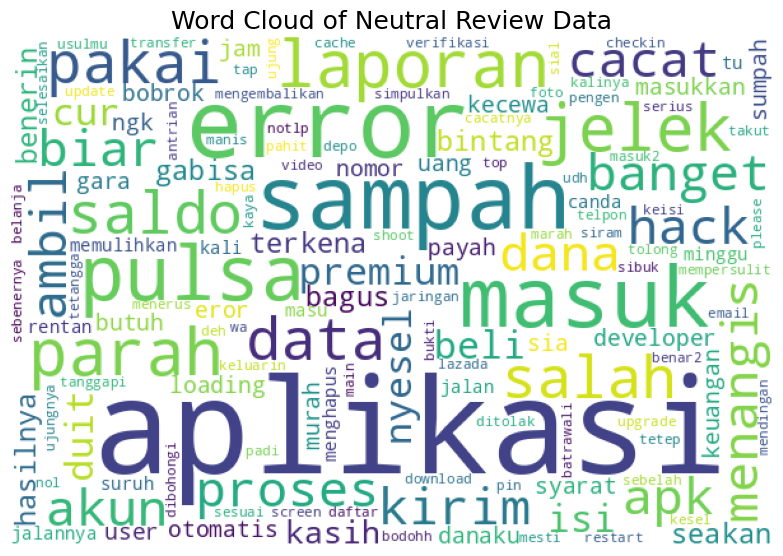

In [23]:
list_words = ''

for tweet in neutral_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Review Data', fontsize=18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

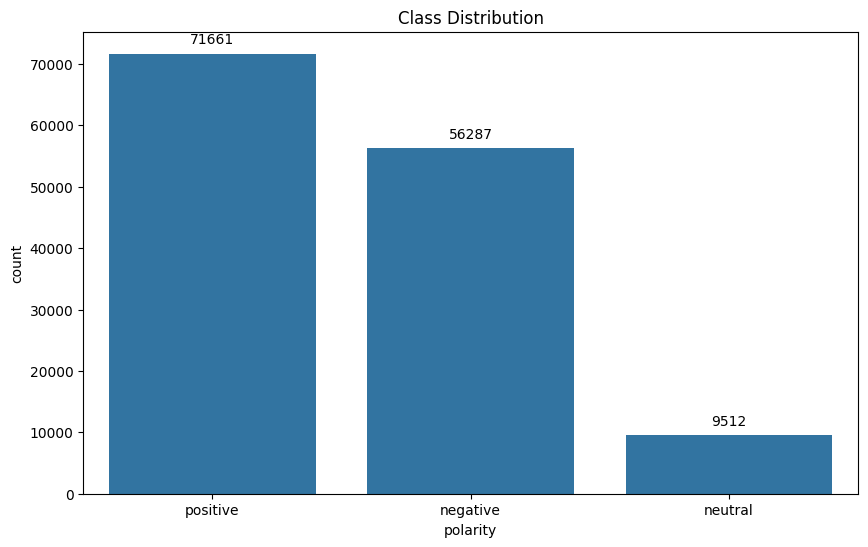

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

plt.figure(figsize=(10, 6))

class_dist_plot = sns.countplot(x='polarity', data=clean_dana_df)
plt.title('Class Distribution')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

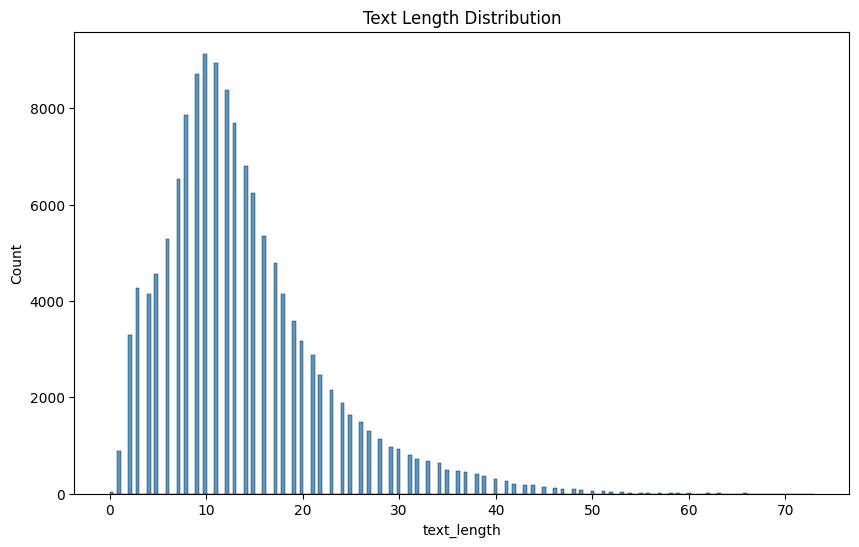

In [25]:
plt.figure(figsize=(10, 6))

clean_dana_df['text_length'] = clean_dana_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(clean_dana_df['text_length'])
plt.title('Text Length Distribution')

plt.show()

# 4. Data Splitting & Modeling

## Skema 1
Model: Sequential
<br>
Ekstraksi Fitur: TF-IDF
<br>
Splitting Data: 80/20

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X = clean_dana_df['text_akhir']
y = clean_dana_df['polarity']

min_df_value = int(0.001 * len(clean_dana_df))

tfidf = TfidfVectorizer(max_features=700, min_df=min_df_value, max_df=0.8, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df.head()

,10,100,24,24 jam,2x,50,admin,akses,aktif,akun,...,versi,versi terbaru,via,via email,voucher,wa,wajah,whatsapp,wifi,yah
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.376065,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

In [28]:
num_samples_X_resampled = X_resampled.shape[0]
num_samples_y_resampled = len(y_resampled)

print(f'Length of X_resampled: {num_samples_X_resampled}')
print(f'Length of y_resampled: {num_samples_y_resampled}')

Length of X_resampled: 214983
Length of y_resampled: 214983


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded, num_classes=3)
y_test_categorical = to_categorical(y_test_encoded, num_classes=3)

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [31]:
y_train_categorical_df = pd.DataFrame(y_train_categorical, columns=['negative', 'neutral', 'positive'])
y_test_categorical_df = pd.DataFrame(y_test_categorical, columns=['negative', 'neutral', 'positive'])

# Tampilkan beberapa baris pertama dari hasil one-hot encoding
print("Training Data One-Hot Encoding:")
print(y_train_categorical_df.head())

print("\nTesting Data One-Hot Encoding:")
print(y_test_categorical_df.head())

Training Data One-Hot Encoding:
   negative  neutral  positive
0       1.0      0.0       0.0
1       0.0      0.0       1.0
2       0.0      0.0       1.0
3       1.0      0.0       0.0
4       0.0      0.0       1.0

Testing Data One-Hot Encoding:
   negative  neutral  positive
0       0.0      0.0       1.0
1       0.0      0.0       1.0
2       0.0      1.0       0.0
3       0.0      1.0       0.0
4       1.0      0.0       0.0


In [32]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(momentum=0.9))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
import numpy as np
from sklearn.utils import shuffle

def data_generator(X, y, batch_size=32):
    while True:
        X, y = shuffle(X, y)
        for start in range(0, X.shape[0], batch_size):
            end = min(start + batch_size, X.shape[0])
            yield X[start:end].toarray(), y[start:end]

batch_size = 32
train_generator = data_generator(X_train, y_train_categorical, batch_size)
validation_generator = data_generator(X_test, y_test_categorical, batch_size)

In [34]:
class AccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      accuracy = logs.get('accuracy')
      loss = logs.get('loss')
      if accuracy > 0.93 and loss < 0.13 :
          print("\nAkurasi telah mencapai lebih dari 95% dan loss di bawah 13% Menghentikan pelatihan...")
          self.model.stop_training = True

In [35]:
history = model.fit(train_generator,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=X_test.shape[0] // batch_size, callbacks=[AccuracyCallback()], verbose=1)

train_loss, train_accuracy = model.evaluate(X_train.toarray(), y_train_categorical, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test.toarray(), y_test_categorical, verbose=0)

Epoch 1/50
5374/5374 [==============================] - 35s 6ms/step - loss: 0.4222 - accuracy: 0.8440 - val_loss: 0.3314 - val_accuracy: 0.8833
Epoch 2/50
5374/5374 [==============================] - 31s 6ms/step - loss: 0.2918 - accuracy: 0.9022 - val_loss: 0.2817 - val_accuracy: 0.9054
Epoch 3/50
5374/5374 [==============================] - 31s 6ms/step - loss: 0.2376 - accuracy: 0.9223 - val_loss: 0.2681 - val_accuracy: 0.9110
Epoch 4/50
5374/5374 [==============================] - 32s 6ms/step - loss: 0.2042 - accuracy: 0.9343 - val_loss: 0.2653 - val_accuracy: 0.9126
Epoch 5/50
5374/5374 [==============================] - 32s 6ms/step - loss: 0.1795 - accuracy: 0.9421 - val_loss: 0.2687 - val_accuracy: 0.9134
Epoch 6/50
5374/5374 [==============================] - 31s 6ms/step - loss: 0.1602 - accuracy: 0.9490 - val_loss: 0.2668 - val_accuracy: 0.9191
Epoch 7/50
5374/5374 [==============================] - 30s 6ms/step - loss: 0.1428 - accuracy: 0.9545 - val_loss: 0.2738 - val_ac

In [36]:
print('Skema 1:')
print('Sequantial + TF-IDF + Splitting Data 80/20')
print('\nHasil:')
print('Train accuracy: {:.2f}'.format(train_accuracy))
print('Test accuracy: {:.2f}'.format(test_accuracy))

Skema 1:
Sequantial + TF-IDF + Splitting Data 80/20

Hasil:
Train accuracy: 0.97
Test accuracy: 0.92


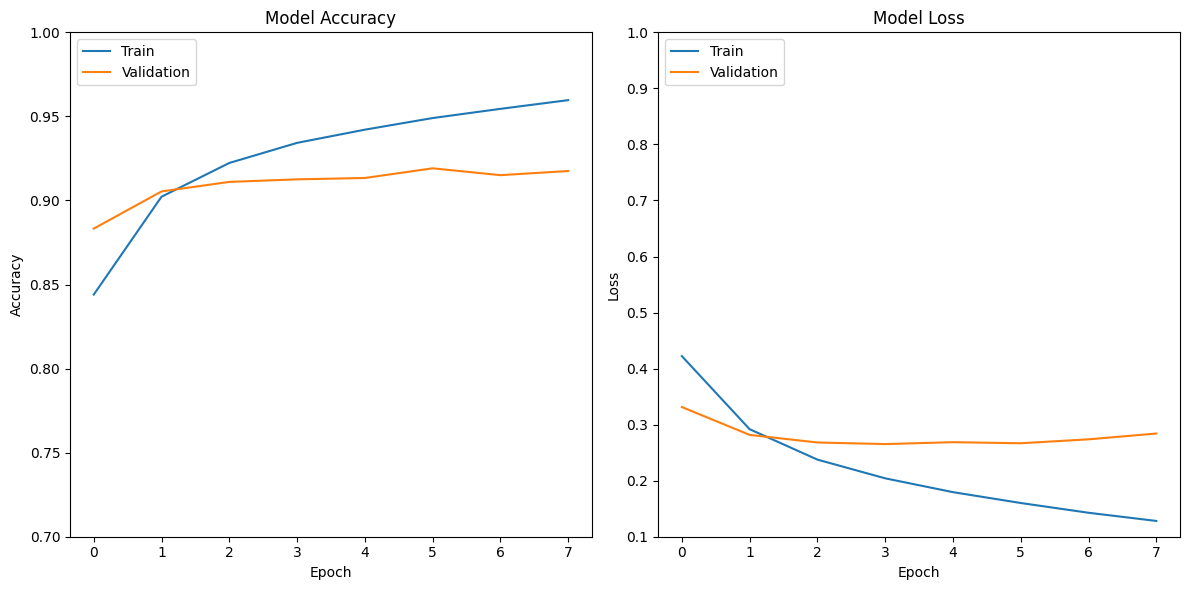

In [47]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.70, 1.0)

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.10, 1.0)

# Menampilkan plot
plt.tight_layout()
plt.show()

## Prediksi Skema 1

In [38]:
new_texts = ["Aplikasi tidak responsif, berjalan lambat, resolusi dokumen digitalnya juga rendah shg kurang jernih. Tambahkan fitur download dokumen, karena sampai saat itu soft copy dokumenlah yang sangat dibutuhkan saat pengumpulan berkas. Rekrut tim IT yang andal agar UI dan UX aplikasinya memuaskan pengguna",
             "Jauh-jauh ke kecamatan mau cetak e-ktp karena habis ganti foto disuruh daftar IKD datang dari jam 9 pagi sampai jam 3 sore KTP tidak bisa dicetak juga alasan data tidak singkron. Kalau memang nggak sinkron kenapa bisa sampai ganti foto KTP dan dapat email bisa dicetak e-ktp nya. Nggak jelas nyampein aja.lama, ribet",
             "Aplikasi ini sangat berguna untuk setiap transaksi, mudah digunakan, dan cara penggunaannya tidak rumit. Proses top up juga tidak sulit karena bisa dilakukan di mana saja. Semoga kualitasnya semakin baik ke depannya dan fiturnya semakin lengkap, seperti fitur paylater. Sukses selalu",
             "Aplikasinya sangat lambat. Semua terasa berat, tidak seperti tahun-tahun sebelumnya. Tolong kepada pihak developer, jangan karena sekarang banyak yang menggunakan, performa sistemnya malah semakin buruk. Kinerjanya juga perlu ditingkatkan. Padahal memori ponsel saya sudah cukup baik, tapi setiap kali masuk, sangat lambat dan terus berputar seperti sibuk, apalagi saat melakukan transaksi di jam-jam tertentu. Sangat mengecewakan.",
             "Aplikasi ini sangat bagus dan berguna untuk transfer antar bank, dengan banyak promo dan diskon untuk pembelian pulsa atau paket data. Lebih ekonomis membeli pulsa melalui aplikasi ini. Terima kasih DANA!",
             "Aplikasi ini berfungsi seperti yang diharapkan untuk melakukan transaksi. Fitur-fiturnya cukup standar, dan prosesnya tidak terlalu rumit. Namun, tidak ada yang mencolok atau khusus mengenai pengalaman pengguna saya sejauh ini",
             "Yaaaa cukup lah"]

new_texts_tfidf = tfidf.transform(new_texts)
new_texts_tfidf_dense = new_texts_tfidf.toarray()

predictions = model.predict(new_texts_tfidf_dense)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Tampilkan hasil prediksi
print("Hasil Pediksi:")

for i, (text, label) in enumerate(zip(new_texts, predicted_labels), 1):
    print(f"Review ke-{i}: {text}")
    print(f"Sentimen: {label}\n")

1/1 [==============================] - 0s 126ms/step
Hasil Pediksi:
Review ke-1: Aplikasi tidak responsif, berjalan lambat, resolusi dokumen digitalnya juga rendah shg kurang jernih. Tambahkan fitur download dokumen, karena sampai saat itu soft copy dokumenlah yang sangat dibutuhkan saat pengumpulan berkas. Rekrut tim IT yang andal agar UI dan UX aplikasinya memuaskan pengguna
Sentimen: negative

Review ke-2: Jauh-jauh ke kecamatan mau cetak e-ktp karena habis ganti foto disuruh daftar IKD datang dari jam 9 pagi sampai jam 3 sore KTP tidak bisa dicetak juga alasan data tidak singkron. Kalau memang nggak sinkron kenapa bisa sampai ganti foto KTP dan dapat email bisa dicetak e-ktp nya. Nggak jelas nyampein aja.lama, ribet
Sentimen: negative

Review ke-3: Aplikasi ini sangat berguna untuk setiap transaksi, mudah digunakan, dan cara penggunaannya tidak rumit. Proses top up juga tidak sulit karena bisa dilakukan di mana saja. Semoga kualitasnya semakin baik ke depannya dan fiturnya semakin 

## Skema 2
Model: Convolutional Layer
<br>
Ekstraksi Fitur: TF-IDF
<br>
Splitting Data: 70/30

In [39]:
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded, num_classes=3)
y_test_categorical = to_categorical(y_test_encoded, num_classes=3)

In [41]:
cv_model = Sequential()
cv_model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cv_model.add(MaxPooling1D(pool_size=2))
cv_model.add(Conv1D(128, kernel_size=3, activation='relu'))
cv_model.add(MaxPooling1D(pool_size=2))
cv_model.add(Flatten())
cv_model.add(Dense(64, activation='relu'))
cv_model.add(Dense(64, activation='relu'))
cv_model.add(Dropout(0.4))
cv_model.add(BatchNormalization(momentum=0.9))
cv_model.add(Dense(3, activation='softmax'))

cv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
def data_generator(X, y, batch_size=32):
    while True:
        X, y = shuffle(X, y)
        for start in range(0, X.shape[0], batch_size):
            end = min(start + batch_size, X.shape[0])
            yield X[start:end].toarray(), y[start:end]

batch_size = 32
train_generator = data_generator(X_train, y_train_categorical, batch_size)
validation_generator = data_generator(X_test, y_test_categorical, batch_size)

In [43]:
cv_history = cv_model.fit(train_generator,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=X_test.shape[0] // batch_size,
                    callbacks=[AccuracyCallback()], verbose=1)

cv_train_loss, cv_train_accuracy = model.evaluate(X_train.toarray(), y_train_categorical, verbose=0)
cv_test_loss, cv_test_accuracy = model.evaluate(X_test.toarray(), y_test_categorical, verbose=0)


Epoch 1/50
4702/4702 [==============================] - 49s 10ms/step - loss: 0.5141 - accuracy: 0.8032 - val_loss: 0.4010 - val_accuracy: 0.8538
Epoch 2/50
4702/4702 [==============================] - 44s 9ms/step - loss: 0.3992 - accuracy: 0.8590 - val_loss: 0.3629 - val_accuracy: 0.8680
Epoch 3/50
4702/4702 [==============================] - 44s 9ms/step - loss: 0.3435 - accuracy: 0.8816 - val_loss: 0.3291 - val_accuracy: 0.8828
Epoch 4/50
4702/4702 [==============================] - 44s 9ms/step - loss: 0.2998 - accuracy: 0.8991 - val_loss: 0.3109 - val_accuracy: 0.8921
Epoch 5/50
4702/4702 [==============================] - 41s 9ms/step - loss: 0.2653 - accuracy: 0.9106 - val_loss: 0.3126 - val_accuracy: 0.8938
Epoch 6/50
4702/4702 [==============================] - 40s 9ms/step - loss: 0.2408 - accuracy: 0.9192 - val_loss: 0.3271 - val_accuracy: 0.8872
Epoch 7/50
4702/4702 [==============================] - 41s 9ms/step - loss: 0.2186 - accuracy: 0.9274 - val_loss: 0.3155 - val_a

In [44]:
print('Skema 2:')
print('Convolutional Layer + TF-IDF + Splitting Data 70/30')
print('\nHasil:')
print('Train accuracy: {:.2f}'.format(cv_train_accuracy))
print('Test accuracy: {:.2f}'.format(cv_test_accuracy))

Skema 2:
Convolutional Layer + TF-IDF + Splitting Data 70/30

Hasil:
Train accuracy: 0.97
Test accuracy: 0.94


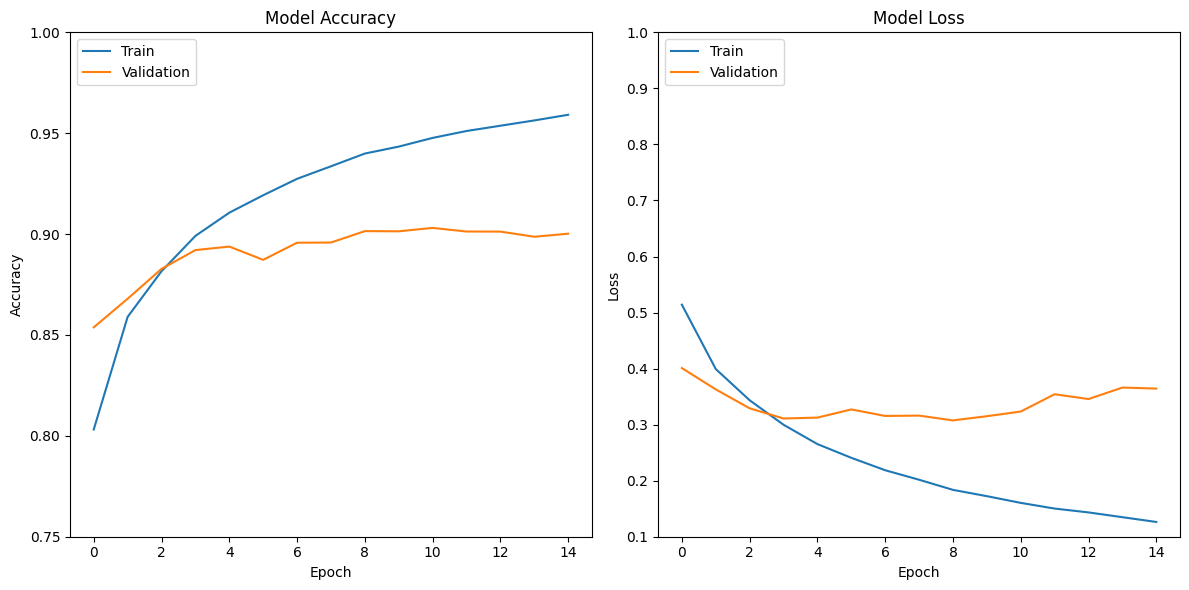

In [45]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cv_history.history['accuracy'])
plt.plot(cv_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.75, 1.0)

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(cv_history.history['loss'])
plt.plot(cv_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.10, 1.0)

# Menampilkan plot
plt.tight_layout()
plt.show()

## Prediksi Skema 2

In [49]:
new_texts = ["Aplikasi tidak responsif, berjalan lambat, resolusi dokumen digitalnya juga rendah shg kurang jernih. Tambahkan fitur download dokumen, karena sampai saat itu soft copy dokumenlah yang sangat dibutuhkan saat pengumpulan berkas. Rekrut tim IT yang andal agar UI dan UX aplikasinya memuaskan pengguna",
             "Jauh-jauh ke kecamatan mau cetak e-ktp karena habis ganti foto disuruh daftar IKD datang dari jam 9 pagi sampai jam 3 sore KTP tidak bisa dicetak juga alasan data tidak singkron. Kalau memang nggak sinkron kenapa bisa sampai ganti foto KTP dan dapat email bisa dicetak e-ktp nya. Nggak jelas nyampein aja.lama, ribet",
             "Aplikasi ini sangat berguna untuk setiap transaksi, mudah digunakan, dan cara penggunaannya tidak rumit. Proses top up juga tidak sulit karena bisa dilakukan di mana saja. Semoga kualitasnya semakin baik ke depannya dan fiturnya semakin lengkap, seperti fitur paylater. Sukses selalu",
             "Aplikasi ini sangat bagus dan berguna untuk transfer antar bank, dengan banyak promo dan diskon untuk pembelian pulsa atau paket data. Lebih ekonomis membeli pulsa melalui aplikasi ini. Terima kasih DANA!",
             "Yaaaa cukup lah",
             "Aplikasi ini berfungsi seperti yang diharapkan untuk melakukan transaksi. Fitur-fiturnya cukup standar, dan prosesnya tidak terlalu rumit. Namun, tidak ada yang mencolok atau khusus mengenai pengalaman pengguna saya sejauh ini",
             "Terimakasih walau masih banyak kekurangan di aplikasinya"
             ]

new_texts_tfidf = tfidf.transform(new_texts)
new_texts_tfidf_dense = new_texts_tfidf.toarray()

predictions = cv_model.predict(new_texts_tfidf_dense)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Tampilkan hasil prediksi
print("Hasil Pediksi:")

for i, (text, label) in enumerate(zip(new_texts, predicted_labels), 1):
    print(f"Review ke-{i}: {text}")
    print(f"Sentimen: {label}\n")

1/1 [==============================] - 0s 102ms/step
Hasil Pediksi:
Review ke-1: Aplikasi tidak responsif, berjalan lambat, resolusi dokumen digitalnya juga rendah shg kurang jernih. Tambahkan fitur download dokumen, karena sampai saat itu soft copy dokumenlah yang sangat dibutuhkan saat pengumpulan berkas. Rekrut tim IT yang andal agar UI dan UX aplikasinya memuaskan pengguna
Sentimen: negative

Review ke-2: Jauh-jauh ke kecamatan mau cetak e-ktp karena habis ganti foto disuruh daftar IKD datang dari jam 9 pagi sampai jam 3 sore KTP tidak bisa dicetak juga alasan data tidak singkron. Kalau memang nggak sinkron kenapa bisa sampai ganti foto KTP dan dapat email bisa dicetak e-ktp nya. Nggak jelas nyampein aja.lama, ribet
Sentimen: negative

Review ke-3: Aplikasi ini sangat berguna untuk setiap transaksi, mudah digunakan, dan cara penggunaannya tidak rumit. Proses top up juga tidak sulit karena bisa dilakukan di mana saja. Semoga kualitasnya semakin baik ke depannya dan fiturnya semakin 

## Skema 3
Model: Convolutional
<br>
Ekstraksi Fitur: TF-IDF
<br>
Splitting Data: 80/20

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded, num_classes=3)
y_test_categorical = to_categorical(y_test_encoded, num_classes=3)

In [51]:
cv2_model = Sequential()
cv2_model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cv2_model.add(MaxPooling1D(pool_size=2))
cv2_model.add(Conv1D(128, kernel_size=3, activation='relu'))
cv2_model.add(MaxPooling1D(pool_size=2))
cv2_model.add(Flatten())
cv2_model.add(Dense(64, activation='relu'))
cv2_model.add(Dense(64, activation='relu'))
cv2_model.add(Dropout(0.4))
cv2_model.add(BatchNormalization(momentum=0.9))
cv2_model.add(Dense(3, activation='softmax'))

cv2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
def data_generator(X, y, batch_size=64):
    while True:
        X, y = shuffle(X, y)
        for start in range(0, X.shape[0], batch_size):
            end = min(start + batch_size, X.shape[0])
            yield X[start:end].toarray(), y[start:end]

batch_size = 64
train_generator = data_generator(X_train, y_train_categorical, batch_size)
validation_generator = data_generator(X_test, y_test_categorical, batch_size)

In [53]:
cv2_history = cv2_model.fit(train_generator,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=X_test.shape[0] // batch_size, callbacks=[AccuracyCallback()], verbose=1)

cv2_train_loss, cv2_train_accuracy = cv2_model.evaluate(X_train.toarray(), y_train_categorical, verbose=0)
cv2_test_loss, cv2_test_accuracy = cv2_model.evaluate(X_test.toarray(), y_test_categorical, verbose=0)

Epoch 1/50
2687/2687 [==============================] - 33s 11ms/step - loss: 0.4930 - accuracy: 0.8121 - val_loss: 0.3835 - val_accuracy: 0.8625
Epoch 2/50
2687/2687 [==============================] - 33s 12ms/step - loss: 0.3784 - accuracy: 0.8661 - val_loss: 0.3432 - val_accuracy: 0.8764
Epoch 3/50
2687/2687 [==============================] - 32s 12ms/step - loss: 0.3208 - accuracy: 0.8891 - val_loss: 0.3184 - val_accuracy: 0.8903
Epoch 4/50
2687/2687 [==============================] - 30s 11ms/step - loss: 0.2804 - accuracy: 0.9044 - val_loss: 0.3045 - val_accuracy: 0.8953
Epoch 5/50
2687/2687 [==============================] - 31s 11ms/step - loss: 0.2490 - accuracy: 0.9159 - val_loss: 0.2965 - val_accuracy: 0.8959
Epoch 6/50
2687/2687 [==============================] - 30s 11ms/step - loss: 0.2219 - accuracy: 0.9262 - val_loss: 0.2894 - val_accuracy: 0.9003
Epoch 7/50
2687/2687 [==============================] - 33s 12ms/step - loss: 0.2033 - accuracy: 0.9323 - val_loss: 0.3051 -

In [54]:
print('Skema 3:')
print('Convolutional Layer + TF-IDF + Splitting Data 80/20')
print('\nHasil:')
print('Train accuracy: {:.2f}'.format(cv2_train_accuracy))
print('Test accuracy: {:.2f}'.format(cv2_test_accuracy))

Skema 3:
Convolutional Layer + TF-IDF + Splitting Data 80/20

Hasil:
Train accuracy: 0.97
Test accuracy: 0.91


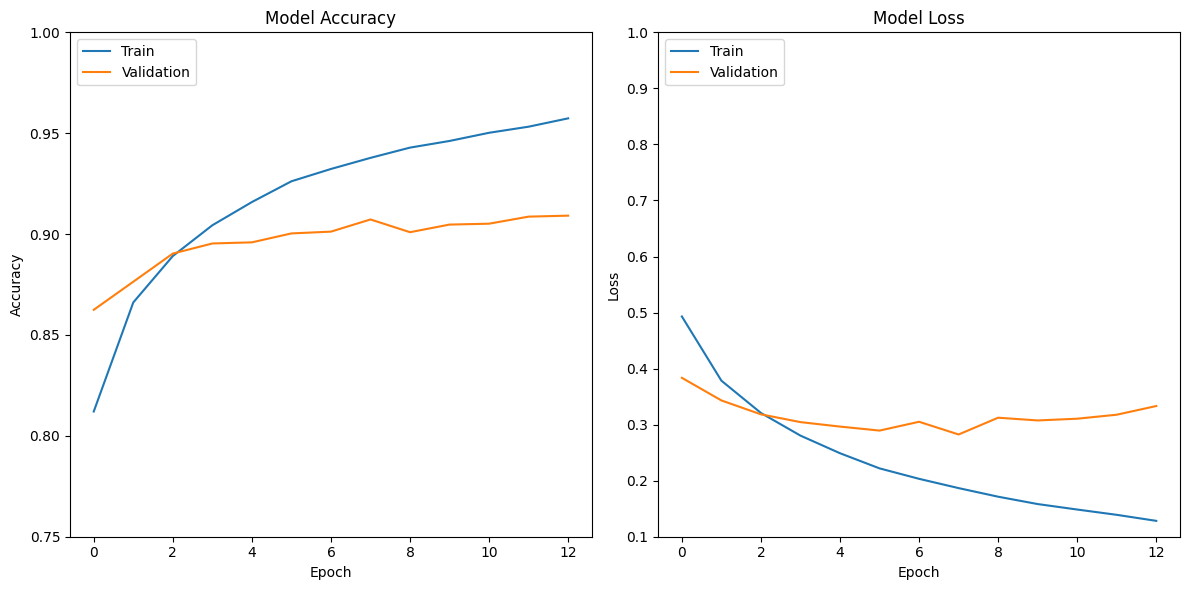

In [55]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cv2_history.history['accuracy'])
plt.plot(cv2_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.75, 1.0)

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(cv2_history.history['loss'])
plt.plot(cv2_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.10, 1.0)

# Menampilkan plot
plt.tight_layout()
plt.show()

## Prediksi Skema 3

In [56]:
new_texts = ["Aplikasi tidak responsif, berjalan lambat, resolusi dokumen digitalnya juga rendah shg kurang jernih. Tambahkan fitur download dokumen, karena sampai saat itu soft copy dokumenlah yang sangat dibutuhkan saat pengumpulan berkas. Rekrut tim IT yang andal agar UI dan UX aplikasinya memuaskan pengguna",
             "Jauh-jauh ke kecamatan mau cetak e-ktp karena habis ganti foto disuruh daftar IKD datang dari jam 9 pagi sampai jam 3 sore KTP tidak bisa dicetak juga alasan data tidak singkron. Kalau memang nggak sinkron kenapa bisa sampai ganti foto KTP dan dapat email bisa dicetak e-ktp nya. Nggak jelas nyampein aja.lama, ribet",
             "Aplikasi ini sangat berguna untuk setiap transaksi, mudah digunakan, dan cara penggunaannya tidak rumit. Proses top up juga tidak sulit karena bisa dilakukan di mana saja. Semoga kualitasnya semakin baik ke depannya dan fiturnya semakin lengkap, seperti fitur paylater. Sukses selalu",
             "Aplikasi ini sangat bagus dan berguna untuk transfer antar bank, dengan banyak promo dan diskon untuk pembelian pulsa atau paket data. Lebih ekonomis membeli pulsa melalui aplikasi ini. Terima kasih DANA!",
             "Yaaaa cukup lah",
             "Aplikasi ini berfungsi seperti yang diharapkan untuk melakukan transaksi. Fitur-fiturnya cukup standar, dan prosesnya tidak terlalu rumit. Namun, tidak ada yang mencolok atau khusus mengenai pengalaman pengguna saya sejauh ini",
             "Terimakasih walau masih banyak kekurangan di aplikasinya"
             ]

new_texts_tfidf = tfidf.transform(new_texts)
new_texts_tfidf_dense = new_texts_tfidf.toarray()

predictions = cv2_model.predict(new_texts_tfidf_dense)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Tampilkan hasil prediksi
print("Hasil Pediksi:")

for i, (text, label) in enumerate(zip(new_texts, predicted_labels), 1):
    print(f"Review ke-{i}: {text}")
    print(f"Sentimen: {label}\n")

1/1 [==============================] - 0s 105ms/step
Hasil Pediksi:
Review ke-1: Aplikasi tidak responsif, berjalan lambat, resolusi dokumen digitalnya juga rendah shg kurang jernih. Tambahkan fitur download dokumen, karena sampai saat itu soft copy dokumenlah yang sangat dibutuhkan saat pengumpulan berkas. Rekrut tim IT yang andal agar UI dan UX aplikasinya memuaskan pengguna
Sentimen: negative

Review ke-2: Jauh-jauh ke kecamatan mau cetak e-ktp karena habis ganti foto disuruh daftar IKD datang dari jam 9 pagi sampai jam 3 sore KTP tidak bisa dicetak juga alasan data tidak singkron. Kalau memang nggak sinkron kenapa bisa sampai ganti foto KTP dan dapat email bisa dicetak e-ktp nya. Nggak jelas nyampein aja.lama, ribet
Sentimen: negative

Review ke-3: Aplikasi ini sangat berguna untuk setiap transaksi, mudah digunakan, dan cara penggunaannya tidak rumit. Proses top up juga tidak sulit karena bisa dilakukan di mana saja. Semoga kualitasnya semakin baik ke depannya dan fiturnya semakin 

---

# Ringkasan Modeling

In [59]:
import pandas as pd
from tabulate import tabulate

data = {
    "Skema": [
        "Sequential + TF-IDF + Splitting Data 80/20",
        "Convolutional Layer + TF-IDF + Splitting Data 70/30",
        "Convolutional Layer + TF-IDF + Splitting Data 80/20"
    ],
    "Train Accuracy": [
        round(train_accuracy, 2),
        round(cv_train_accuracy, 2),
        round(cv2_train_accuracy, 2)
    ],
    "Test Accuracy": [
        round(test_accuracy, 2),
        round(cv_test_accuracy, 2),
        round(cv2_test_accuracy, 2)
    ]
}

df = pd.DataFrame(data)
print(tabulate(df, headers='keys', tablefmt='grid', numalign='center', stralign='center', showindex=False))


+-----------------------------------------------------+------------------+-----------------+
|                        Skema                        |  Train Accuracy  |  Test Accuracy  |
+=====================================================+==================+=================+
|     Sequential + TF-IDF + Splitting Data 80/20      |       0.97       |      0.92       |
+-----------------------------------------------------+------------------+-----------------+
| Convolutional Layer + TF-IDF + Splitting Data 70/30 |       0.97       |      0.94       |
+-----------------------------------------------------+------------------+-----------------+
| Convolutional Layer + TF-IDF + Splitting Data 80/20 |       0.97       |      0.91       |
+-----------------------------------------------------+------------------+-----------------+


Membuat Requirement.txt

In [60]:
!pip freeze > requirements.txt